
# Genetikus algoritmusok – Egyedábrázolások és operátorok (HU)

**Cél:** bemutatni és kipróbálni a leggyakoribb egyedábrázolásokat (bináris, valós, permutáció, fa, gráf/szabályhalmaz), a genotípus–fenotípus leképezést és a hozzájuk illeszkedő genetikai operátorokat (keresztezés, mutáció).

**Fő fogalmak jelölése:**
- **Egyed = genotípus:** a megoldás **kódolt** formája (pl. bitlánc, vektor, permutáció, fa, gráf).
- **Fenotípus:** a kódolt genotípus által reprezentált **értelmezett megoldás** a probléma terében.
- **Genotípus–fenotípus leképezés:** determinisztikus és **egyértelmű** legyen.
- **Operátorok igazítása:** a (crossover, mutáció) operátorokat **az ábrázoláshoz kell illeszteni**.
- **Egyszerű, de kifejező kódolás** előny: könnyebb implementáció + hatékony keresés.

---

## Telepítés (Colab esetén futtasd egyszer)


In [ ]:

# Colab/Notebook környezet előkészítése
# Szükség esetén futtasd ezt a cellát
!pip -q install sympy networkx


In [ ]:

# Importok
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import List, Tuple

import sympy as sp
from sympy import symbols
from sympy.parsing.sympy_parser import parse_expr

# Jupyter beállítások
np.set_printoptions(precision=4, suppress=True)



## 1) Genotípus vs. Fenotípus

- **Genotípus:** az egyed **kódolt** formája, amelyen az evolúciós operátorok (keresztezés, mutáció) dolgoznak.
- **Fenotípus:** a genotípus **értelmezett** formája a feladat terében (pl. numerikus érték, útvonal, kifejezés értéke, hálózat).
- A leképezés legyen **egyértelmű**, **determinista**, és lehetőleg **olcsó** (gyors) kiértékelésű.


In [ ]:

# Demonstráció: ugyanaz az információ különböző genotípusokban – azonos fenotípus
# Bináris: [1,1,0,1] -> 13 (decimális)
# Valós: (3.2, -0.7, 1.5) -> pl. f(x)=Σx^2
# Permutáció: (3,5,1,4,2) -> útvonal értéke költségfüggvénnyel

def binary_to_decimal(bitstring: List[int]) -> int:
    return int("".join(map(str, bitstring)), 2)

bit_g = [1,1,0,1]
print("Genotípus (bináris):", bit_g)
print("Fenotípus (decimális):", binary_to_decimal(bit_g))

real_g = np.array([3.2, -0.7, 1.5])
print("\nGenotípus (valós vektor):", real_g)
print("Fenotípus (pl. f(x)=Σx^2):", float(np.sum(real_g**2)))

perm_g = [3,5,1,4,2]
print("\nGenotípus (permutáció):", perm_g)
# Illusztratív költségmátrix (szimmetrikus, 1-indexelt városokhoz)
C = np.array([
    [0, 2, 9, 10, 7],
    [2, 0, 6,  4,  3],
    [9, 6, 0,  8,  5],
    [10,4, 8,  0,  1],
    [7, 3, 5,  1,  0]
])
def tour_cost(perm: List[int], C: np.ndarray) -> float:
    # perm elemei 1..n városok, körút költség
    cost = 0.0
    for i in range(len(perm)):
        a = perm[i]-1
        b = perm[(i+1) % len(perm)]-1
        cost += C[a, b]
    return cost

print("Fenotípus (útvonal-költség):", tour_cost(perm_g, C))


Genotípus (bináris): [1, 1, 0, 1]
Fenotípus (decimális): 13

Genotípus (valós vektor): [ 3.2 -0.7  1.5]
Fenotípus (pl. f(x)=Σx^2): 12.980000000000002

Genotípus (permutáció): [3, 5, 1, 4, 2]
Fenotípus (útvonal-költség): 32.0



## 2) Gyakori egyedábrázolási formák (legalább hármat értsünk is meg)

- **Bináris kódolás**: pl. `[0,1,1,0,1]`
- **Valós értékű kódolás**: pl. `(3.2, -0.7, 1.5)`
- **Permutációs kódolás**: pl. `(3,5,1,4,2)`
- **Fa-struktúrák** (szimbolikus kifejezések): pl. `(x+y)*z`
- **Gráf/szabály-halmaz**: pl. hálózat-topológiák, kapcsolati szabályok

**Mi a különbség a genotípus és a fenotípus között?**  
Lásd az 1. fejezet példáit és magyarázatát.

**Miért előnyös a bináris kódolás? Mik a hátrányai?**
- **Előnyök:** egyszerű implementálni, jól támogatott operátorok (bit-flip mutáció, 1/2-pontos crossover), robusztus.
- **Hátrányok:** folytonos paramétertereknél mesterséges kódolás/kvantálás kell; számosság nőhet; finomhangolás nehezebb.

**Milyen problémákra alkalmas a permutációs kódolás?**  
Útvonal- és sorrend-optimalizálás (TSP, ütemezés, gyártás, logisztika, rangsorolás).

**Hogyan hat az ábrázolás megválasztása az operátorokra?**  
Az operátorokat az ábrázoláshoz kell illeszteni: pl. permutációnál duplikációkat kerülő crossover, fánál részfa-csere, gráfnál él-műveletek stb.



## 3) Bináris kódolás – operátorokkal

**Genotípus:** bitlánc.  
**Fenotípus:** pl. decimális érték (vagy problémaspecifikus dekódolás).  
**Operátorok:** bit-flip mutáció, 1-pontos / 2-pontos keresztezés.


In [ ]:

def binary_mutation(bitstring: List[int], p: float = 0.05) -> List[int]:
    return [1-b if random.random() < p else b for b in bitstring]

def binary_crossover(p1: List[int], p2: List[int]) -> List[int]:
    assert len(p1) == len(p2)
    point = random.randint(1, len(p1)-1)
    return p1[:point] + p2[point:]

# Példa
p1 = [0,0,1,1,0,1,0,1]
p2 = [1,1,0,0,1,0,1,0]
child = binary_crossover(p1, p2)
mut_child = binary_mutation(child, p=0.2)

print("Szülő1:", p1)
print("Szülő2:", p2)
print("Utód  :", child)
print("Mutált:", mut_child)
print("Fenotípus (decimális):", binary_to_decimal(mut_child))


Szülő1: [0, 0, 1, 1, 0, 1, 0, 1]
Szülő2: [1, 1, 0, 0, 1, 0, 1, 0]
Utód  : [0, 0, 0, 0, 1, 0, 1, 0]
Mutált: [0, 0, 0, 0, 0, 1, 1, 0]
Fenotípus (decimális): 6



## 4) Valós értékű kódolás – operátorokkal

**Genotípus:** valós szám vektor.  
**Fenotípus:** feladatfüggő (pl. célfüggvény értéke).  
**Operátorok:** Gauss-mutáció, aritmetikai (BLX/aritmetikai) crossover.


In [ ]:

def real_mutation(x: np.ndarray, sigma: float = 0.1, bounds: Tuple[float,float]=(-5.0, 5.0)) -> np.ndarray:
    y = x + np.random.normal(0, sigma, size=len(x))
    low, high = bounds
    return np.clip(y, low, high)

def real_crossover(p1: np.ndarray, p2: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    return alpha*p1 + (1.0-alpha)*p2

p1 = np.array([1.0, 2.0, 3.0])
p2 = np.array([3.0, 2.0, 1.0])
child = real_crossover(p1, p2, alpha=0.3)
mut_child = real_mutation(child, sigma=0.2, bounds=(-10, 10))

print("Szülő1:", p1)
print("Szülő2:", p2)
print("Utód  :", child)
print("Mutált:", mut_child)
print("Fenotípus (Σx^2):", float(np.sum(mut_child**2)))


Szülő1: [1. 2. 3.]
Szülő2: [3. 2. 1.]
Utód  : [2.4 2.  1.6]
Mutált: [2.388  1.9165 1.8861]
Fenotípus (Σx^2): 12.932920503804793



## 5) Permutációs kódolás – operátorokkal

**Genotípus:** rendezett sorrend/permutáció (pl. városok sorrendje).  
**Fenotípus:** sorrendhez tartozó költség/érték.  
**Operátorok:** duplikáció-mentes crossover (pl. OX-szerű), csere/szegmens mutáció.


In [ ]:

def perm_crossover(p1: List[int], p2: List[int]) -> List[int]:
    assert len(p1) == len(p2)
    n = len(p1)
    i, j = sorted(random.sample(range(n), 2))
    child = [None]*n
    # másold p1[i:j] szeletet
    child[i:j] = p1[i:j]
    # töltsd fel p2 sorrendben a maradék pozíciókat
    fill = [x for x in p2 if x not in child[i:j]]
    k = 0
    for idx in list(range(0, i)) + list(range(j, n)):
        child[idx] = fill[k]
        k += 1
    return child

def perm_mutation_swap(p: List[int]) -> List[int]:
    q = p[:]
    a, b = random.sample(range(len(q)), 2)
    q[a], q[b] = q[b], q[a]
    return q

p1 = [1,2,3,4,5,6,7]
p2 = [7,6,5,4,3,2,1]
child = perm_crossover(p1, p2)
mut_child = perm_mutation_swap(child)

print("Szülő1:", p1)
print("Szülő2:", p2)
print("Utód  :", child)
print("Mutált:", mut_child)

# Fenotípus: példaköltség (körút)
C = np.array([
    [0,2,9,10,7,6,4],
    [2,0,6,4,3,5,8],
    [9,6,0,8,5,7,3],
    [10,4,8,0,1,2,9],
    [7,3,5,1,0,4,6],
    [6,5,7,2,4,0,5],
    [4,8,3,9,6,5,0],
])
def tour_cost_perm(perm: List[int], C: np.ndarray) -> float:
    cost = 0.0
    for i in range(len(perm)):
        a = perm[i]-1
        b = perm[(i+1) % len(perm)]-1
        cost += C[a, b]
    return cost

print("Fenotípus (költség):", tour_cost_perm(mut_child, C))


Szülő1: [1, 2, 3, 4, 5, 6, 7]
Szülő2: [7, 6, 5, 4, 3, 2, 1]
Utód  : [1, 7, 6, 5, 4, 3, 2]
Mutált: [1, 7, 2, 5, 4, 3, 6]
Fenotípus (költség): 37.0



## 6) Fa-struktúrás (szimbolikus) kódolás – operátorokkal

**Genotípus:** szimbolikus kifejezésfa (pl. `(x+y)*z`).  
**Fenotípus:** kiértékelt kifejezés egy konkrét inputon.  
**Operátorok:** részfa-csere (crossover), részfa-helyettesítés (mutáció).

> Megjegyzés: oktatási céllal egyszerűsítettük a fa-operátorokat; valós GP (Genetic Programming) rendszerekben típus- és grammatika-korlátokkal dolgozunk.


In [ ]:

x, y, z = symbols('x y z')

def random_expr(depth=2):
    vars_ = [x, y, z]
    ops = [sp.Add, sp.Mul]
    if depth == 0:
        return random.choice(vars_ + [sp.Integer(random.randint(-3,3))])
    left = random_expr(depth-1)
    right = random_expr(depth-1)
    op = random.choice(ops)
    return op(left, right)

def subtree_replace(expr, target, replacement):
    return expr.xreplace({target: replacement})

def get_subexpressions(expr):
    # Visszaadja az összes részfát (csomópontot)
    return list(sp.preorder_traversal(expr))

# Példa két kifejezésre
e1 = parse_expr("(x + y) * z")
e2 = parse_expr("x * (y + z)")

# Crossover: válassz részfákat és cseréld fel
sub1 = random.choice(get_subexpressions(e1))
sub2 = random.choice(get_subexpressions(e2))
child1 = subtree_replace(e1, sub1, sub2)
child2 = subtree_replace(e2, sub2, sub1)

# Mutáció: cserélj le egy részfát egy véletlen kifejezésre
mut1 = subtree_replace(child1, random.choice(get_subexpressions(child1)), random_expr(depth=1))

print("Szülő1:", e1)
print("Szülő2:", e2)
print("Utód1 :", child1)
print("Utód2 :", child2)
print("Mutált:", mut1)

# Fenotípus: kiértékelés egy pontban
point = {x:1, y:2, z:3}
print("Mutált fenotípus értéke (x=1,y=2,z=3):", mut1.subs(point))


Szülő1: z*(x + y)
Szülő2: x*(y + z)
Utód1 : y
Utód2 : x*(z*(x + y) + z)
Mutált: x + z
Mutált fenotípus értéke (x=1,y=2,z=3): 4



## 7) Gráf / szabályhalmaz-alapú kódolás – operátorokkal

**Genotípus:** csomópontok és élek halmaza (pl. hálózat-topológia).  
**Fenotípus:** pl. topológia tulajdonságai (átlagos fokszám, összefüggőség, átmérő, stb.).  
**Operátorok:** él-hozzáadás/eltávolítás, részgráf-csere (crossover).

> Bioinformatikai példa: génszabályozási hálók, fehérje–fehérje kölcsönhatások, metabolikus utak.


G1 fenotípus: {'avg_degree': 2.0, 'connected': False, 'diameter': None}
G2 fenotípus: {'avg_degree': 1.75, 'connected': False, 'diameter': None}
Utód fenotípus: {'avg_degree': 3.0, 'connected': True, 'diameter': 3}
Mutált fenotípus: {'avg_degree': 3.25, 'connected': True, 'diameter': 3}


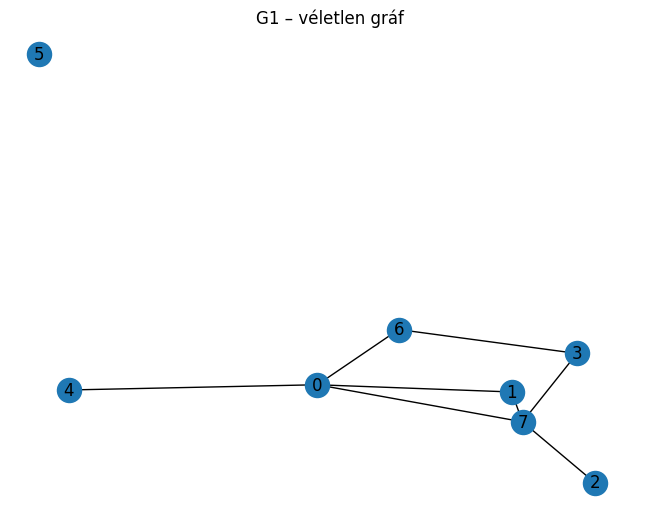

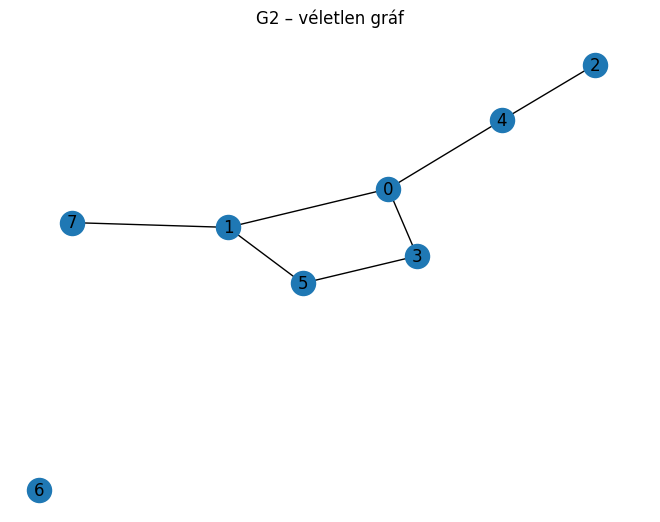

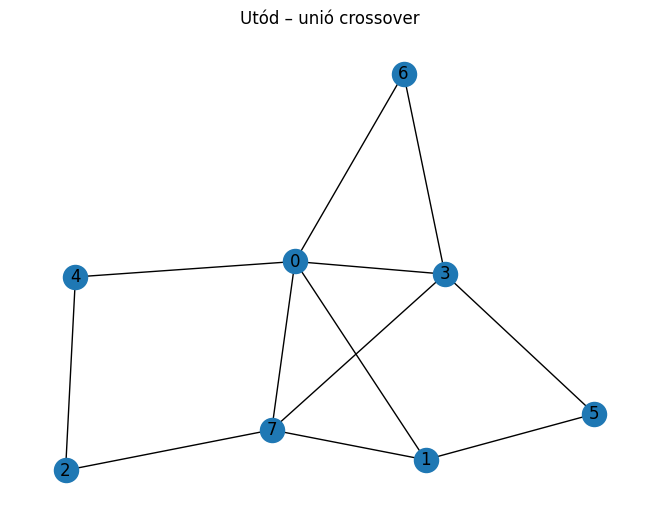

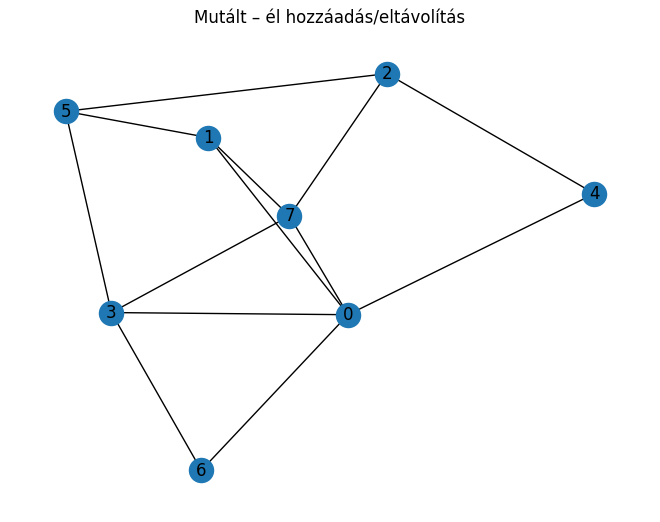

In [ ]:

def random_graph(n=6, p=0.3):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    for i in range(n):
        for j in range(i+1, n):
            if random.random() < p:
                G.add_edge(i, j)
    return G

def graph_mutation_add_or_remove_edge(G):
    H = G.copy()
    n = H.number_of_nodes()
    # 50% esély él hozzáadásra, 50% eltávolításra (ha lehetséges)
    if random.random() < 0.5 and H.number_of_edges() < n*(n-1)//2:
        # Adj hozzá egy még nem létező élt
        possible = [(i,j) for i in range(n) for j in range(i+1, n) if not H.has_edge(i,j)]
        if possible:
            H.add_edge(*random.choice(possible))
    else:
        # Távolíts el egy meglévő élt
        if H.number_of_edges() > 0:
            H.remove_edge(*random.choice(list(H.edges())))
    return H

def graph_crossover_union(G1, G2):
    # Egyszerű unió-crossover: élek uniója (illusztratív)
    H = nx.Graph()
    H.add_nodes_from(G1.nodes())
    H.add_edges_from(G1.edges())
    H.add_edges_from(G2.edges())
    return H

# Példa
G1 = random_graph(n=8, p=0.25)
G2 = random_graph(n=8, p=0.25)
child = graph_crossover_union(G1, G2)
mut_child = graph_mutation_add_or_remove_edge(child)

# Fenotípus-példa: fokszám-eloszlás és összefüggőség
def phenotype_graph_stats(G):
    degrees = [d for _, d in G.degree()]
    connected = nx.is_connected(G) if G.number_of_nodes() > 0 else False
    diameter = nx.diameter(G) if connected and G.number_of_nodes() > 1 else None
    return {
        "avg_degree": float(np.mean(degrees)) if degrees else 0.0,
        "connected": connected,
        "diameter": diameter
    }

print("G1 fenotípus:", phenotype_graph_stats(G1))
print("G2 fenotípus:", phenotype_graph_stats(G2))
print("Utód fenotípus:", phenotype_graph_stats(child))
print("Mutált fenotípus:", phenotype_graph_stats(mut_child))

# Ábra: vizualizáció (egyetlen rajz per grafikon, nem állítunk be színeket)
plt.figure()
nx.draw(G1, with_labels=True)
plt.title("G1 – véletlen gráf")
plt.show()

plt.figure()
nx.draw(G2, with_labels=True)
plt.title("G2 – véletlen gráf")
plt.show()

plt.figure()
nx.draw(child, with_labels=True)
plt.title("Utód – unió crossover")
plt.show()

plt.figure()
nx.draw(mut_child, with_labels=True)
plt.title("Mutált – él hozzáadás/eltávolítás")
plt.show()



## 8) Összefoglalás (Q&A kivonat)

**Mi a különbség a genotípus és a fenotípus között?**  
A genotípus a kódolt megoldás (pl. bitlánc, permutáció), a fenotípus az értelmezett megoldás (pl. számérték, útvonal költség).

**Sorolj fel legalább három egyedábrázolási formát!**  
Bináris, valós, permutáció (plusz: fa, gráf).

**Miért előnyös a bináris kódolás? Mik a hátrányai?**  
Egyszerű, operátorok jól definiáltak; de folytonos terekre kvantálás kell és romolhat a finomság.

**Milyen problémákra alkalmas a permutációs kódolás?**  
Útvonal- és sorrend-optimalizálás, ütemezés, rangsorolás.  

**Hogyan hat az ábrázolás megválasztása az operátorok működésére?**  
Az operátorokat az ábrázoláshoz kell illeszteni (pl. permutációnál duplikáció elkerülése, fáknál részfa-műveletek, gráfoknál él-műveletek).



## 9) Gyakorló feladatok (opcionális)

1. Írj bináris → **valós** dekódolót, amely fixpontos kódolással ábrázolja a \[-5, 5\] intervallumot!
2. Egészítsd ki a valós kódolású mutációt úgy, hogy adaptív legyen (sigma csökkenjen generációról generációra)!
3. Valósíts meg PMX (Partially Mapped Crossover) operátort permutációkra!
4. Fa-struktúrán vezess be **típusos** operátorokat (pl. csak azonos típusú részfák cserélhetőek)!
5. Gráf esetén próbálj ki **topológia-korlátokat** (pl. max fokszám, összefüggőség megőrzése).
